In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
import numpy as np
import pandas as pd

from copy import deepcopy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

/home/ftyuejian/miniconda3/envs/rdkit_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### predefined functions and utilities

In [2]:
def get_feature_name(path):
    """
    get the list of feature name
    :param path:string
    :return:numpy.array()
    """
    data = pd.read_csv(path)

    return list(np.array(data.columns.values))[4:]

In [3]:
def build_ion_dictionary(path):
    """
    build up a dictionary for ion and their fingerprint
    :param path:string
    :return:dict()
    """
    iondict = dict()
    raw_dict = pd.read_csv(path)

    # build up the dictionary
    for value in raw_dict.values:
        try:
            mol = Chem.MolFromSmiles(value[2])
            mol = Chem.AddHs(mol)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
        except:
            print("fingerprint transformation failed")

        if value[0] not in iondict:
            iondict[value[0]] = (fp,value[2])

    return iondict

In [4]:
def feature_embedding(path,ion_dict):
    """
    embed all of the data into fingerprint+T+P
    :param path:string
    :param ion_dict:dict
    :return:tuple
    """
    # value to return
    data_vector = []
    smiles_for_scaffold_split = []
    label = []
    wrapup = []

    raw_data = pd.read_csv(path)
    # visualize
    print(raw_data.columns)

    for data in raw_data.values:
        if data[1] not in ion_dict or data[2] not in ion_dict:
            continue
        # for scaffold spilt
        smiles_for_scaffold_split.append(ion_dict[data[1]][1])

        # embedding
        vector = list(ion_dict[data[1]][0]) + list(ion_dict[data[2]][0]) + [data[4]] + [data[5]]
        data_vector.append(vector)

        # label
        label.append(data[3])

    wrapup.append(np.array(data_vector))
    wrapup.append(np.asarray(smiles_for_scaffold_split))
    wrapup.append(np.array(label))

    return tuple(wrapup)

In [5]:
def feature_origin(path,ion_dict):
    """
    return the original version of embedding using functional group
    :param path:string
    :return:tuple
    """
    embeds = []
    smiles_for_scaffold_split = []
    wrapup = []
    label = []

    datas = pd.read_csv(path)

    for data in datas.values:
        if data[1] not in ion_dict or data[2] not in ion_dict:
            continue
        # for scaffold spilt
        smiles_for_scaffold_split.append(ion_dict[data[1]][1])

        # embed
        embed = data[4:-1] 
        embeds.append(embed)

        # label
        label.append(data[3])

    wrapup.append(np.array(embeds))
    wrapup.append(np.asarray(smiles_for_scaffold_split))
    wrapup.append(np.array(label))

    return tuple(wrapup)

In [6]:
def _generate_scaffold(smiles, include_chirality=False):
    """
    generate Murcko scaffold for input smiles
    :param smiles: string
    :param include_chirality:Boolean
    :return: string
    """
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)

    return scaffold

In [7]:
def generate_scaffolds(smiles_data, log_every_n=1000):
    """
    categorize the molecule into different group accord to there scaffold
    :param smiles_data: list of string
    :param log_every_n: default
    :return: list(list())
    """
    scaffolds = {}  # initialized as a dictionary
    data_len = len(smiles_data)

    print("About to generate scaffolds")
    for ind, smiles in enumerate(smiles_data):
        # just to show the process
        if ind % log_every_n == 0:
            print("Generating scaffold %d/%d" % (ind, data_len))  # way to print number
        # begin from here
        scaffold = _generate_scaffold(smiles)

        # categorized molecule depend on its Murcko scaffold
        if scaffold not in scaffolds:
            scaffolds[scaffold] = [ind]
        else:
            scaffolds[scaffold].append(ind)
            
    # Sort from largest to smallest scaffold sets
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}  # sort index in each category

    scaffold_sets = [
        scaffold_set for (scaffold, scaffold_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)  
    ]
    return scaffold_sets

In [8]:
def scaffold_split(smiles_data, valid_size, test_size, seed=None, log_every_n=1000):
    """
    conduct scaffold splitting
    :param smiles_data:
    :param valid_size:
    :param test_size:
    :param seed:
    :param log_every_n:
    :return: list of index,list of index,list of index
    """


    train_size = 1.0 - valid_size - test_size
    scaffold_sets = generate_scaffolds(smiles_data)  
    train_cutoff = train_size * len(smiles_data)
    valid_cutoff = (train_size + valid_size) * len(smiles_data)
    train_inds: List[int] = []
    valid_inds: List[int] = []
    test_inds: List[int] = []

    print("About to sort in scaffold sets")
    for scaffold_set in scaffold_sets:
        if len(train_inds) + len(scaffold_set) > train_cutoff:
            if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
                test_inds += scaffold_set
            else:
                valid_inds += scaffold_set
        else:
            train_inds += scaffold_set
    return train_inds, valid_inds, test_inds

In [9]:
def random_split( dataset_size , valid_size, test_size ):
    """
    conduct random split on the data set
    :param dataset_size: int
    :param valid_size: float
    :param test_size: float
    :return:list, list, list
    """
    total_ins = list(range(0,dataset_size))
    random.shuffle(total_ins)

    train_cutoff = int(dataset_size*(1-valid_size-test_size))
    test_cutoff = int(dataset_size*test_size)

    train_ins = total_ins[0 : train_cutoff]
    test_ins = total_ins[train_cutoff : train_cutoff + test_cutoff]
    valid_ins = total_ins[train_cutoff + test_cutoff : ]

    return train_ins,valid_ins,test_ins

In [10]:
def plot(labels, predictions,tl,tp,name):
    xymin = min(np.min(labels), np.max(predictions))
    xymax = max(np.max(labels), np.max(predictions))

    fig, ax = plt.subplots(figsize=(8,8))
    print(type(ax))
    ax.scatter(labels, predictions, s=25, edgecolors='None', linewidths=0.4,c = 'orange',label = 'train data')
    ax.scatter(tl, tp, s=25, edgecolors='None', linewidths=0.4,c = 'yellow',label = 'test data')
    x = np.linspace(xymin, xymax)
    y = np.linspace(xymin, xymax)
    ax.plot(x, y, linestyle='dashed', c='black')
    
    ax.set_xlabel('Label', fontsize=18)
    ax.set_ylabel('Prediction', fontsize=18)
    ax.tick_params(direction='in', width=2,labelsize = 15)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.5)
    ax.legend(fontsize = 15)
    plt.savefig(name)

### trainning model based on functional group feature extraction

In [11]:
# build up the dictionary for ion fingerprint
ion_dict = deepcopy(build_ion_dictionary(path = "data/smiles.csv"))

# embedding the data with fingerprint and Temperature,Pressure
wrapdata = deepcopy(feature_origin(path = "data/whole.csv",ion_dict = ion_dict))
data = wrapdata[0].astype(np.float32)
smiles = wrapdata[1]
labels = wrapdata[2]

# verify the embedded data
print("verification")
print(type(data),len(data))
print(type(smiles),len(smiles))
print(type(labels), len(labels))

# perform scaffold splitting on the dataset
train_idx, valid_idx, test_idx = random_split(len(smiles), 0, 0.2)
train_set, train_labels = data[train_idx], labels[train_idx]
valid_set, valid_labels = data[valid_idx], labels[valid_idx]# remember here
test_set, test_labels = data[test_idx], labels[test_idx]

# get the label for the feature
feature_name = get_feature_name("data/whole.csv")
feature_name = list(feature_name)
feature_name.pop()
feature_name = np.array(feature_name)
feature_n = feature_name[2:25]

verification
<class 'numpy.ndarray'> 10116
<class 'numpy.ndarray'> 10116
<class 'numpy.ndarray'> 10116


In [12]:
# XGBoost training
xgb = XGBRegressor(n_estimators=200)
xgb.fit(train_set, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<class 'matplotlib.axes._subplots.AxesSubplot'>


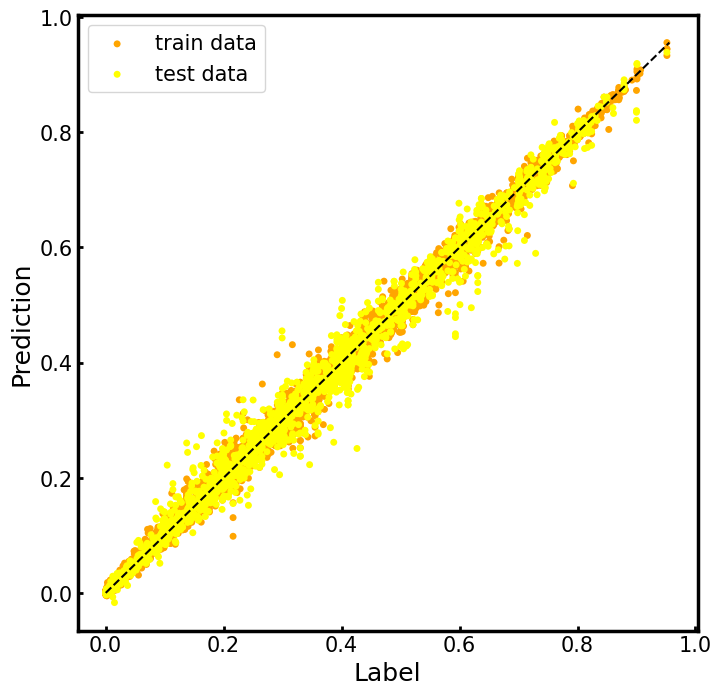

In [13]:
# plot the result
test_predictions = xgb.predict( test_set )
train_predictions = xgb.predict( train_set )
plot(train_labels,train_predictions,test_labels,test_predictions,'XGB_FP')

In [14]:
# evaluation
mae = mean_absolute_error(test_labels, test_predictions)
R = r2_score(test_labels, test_predictions)
print("mae is ",mae)
print("R2 is ", R)

mae is  0.01750224936217693
R2 is  0.9864283434984152


### trainning model based on fingerprint feature extraction

In [15]:
# build up the dictionary for ion fingerprint
ion_dict = deepcopy(build_ion_dictionary(path = "data/smiles.csv"))

# embedding the data with fingerprint and Temperature,Pressure
wrapdata = deepcopy(feature_embedding(path = "data/whole.csv",ion_dict = ion_dict))
data = wrapdata[0].astype(np.float32)
smiles = wrapdata[1]
labels = wrapdata[2]

# verify the embedded data
print("verification")
print(type(data),len(data))
print(type(smiles),len(smiles))
print(type(labels), len(labels))

# perform scaffold splitting on the dataset
train_idx, valid_idx, test_idx = random_split(len(smiles), 0, 0.2)
train_set, train_labels = data[train_idx], labels[train_idx]
valid_set, valid_labels = data[valid_idx], labels[valid_idx]# remember here
test_set, test_labels = data[test_idx], labels[test_idx]

# get the label for the feature
feature_name = get_feature_name("data/whole.csv")
feature_name = list(feature_name)
feature_name.pop()
feature_name = np.array(feature_name)
feature_n = feature_name[2:25]

Index(['IL', 'cation', 'anion', 'x_CO2', 'T (K)', 'P (bar)', '[CH3]', '[CH2]',
       '[CH]', '[OCH2]', '[OCH3]', '[CF2]', '[CF3]', '[OH]', 'CH=CH', 'CH=CH2',
       '[Im13]', '[MIm]', '[MMIM]', '[Py]', '[MPy]', '[MPyrro]', '[MPip]',
       '[NH3]', '[NH2]', '[NH]', '[N]', '[P]', '[S]', '[BF4]', '[Cl]', '[DCA]',
       '[NO3]', '[PF6]', '[SCN]', '[TCB]', '[C(CN)3]', '[HSO4]', '[FSA]',
       '[Tf2N]', '[BETA]', '[FOR]', '[TFA]', '[C3F7CO2]', '[MeSO4]', '[EtSO4]',
       '[MDEGSO4]', '[MeSO3]', '[TfO]', '[NfO]', '[TDfO]', '[TOS]',
       '[C12PhSO3]', '[DMPO4]', '[DEPO4]', '[DBPO4]', '[methide]',
       'Unnamed: 57'],
      dtype='object')
verification
<class 'numpy.ndarray'> 10116
<class 'numpy.ndarray'> 10116
<class 'numpy.ndarray'> 10116


In [16]:
# XGBoost training
xgb = XGBRegressor(n_estimators=200)
xgb.fit(train_set, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<class 'matplotlib.axes._subplots.AxesSubplot'>


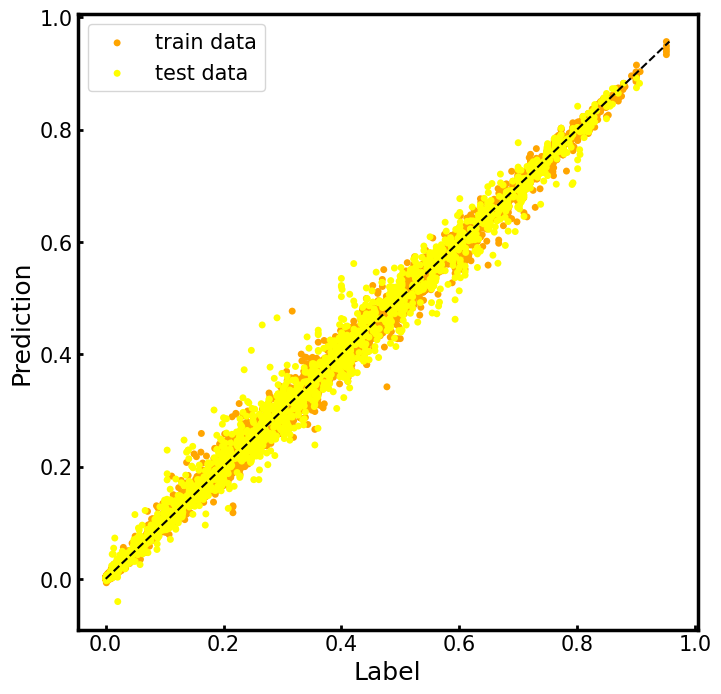

In [17]:
# plot the result
test_predictions = xgb.predict( test_set )
train_predictions = xgb.predict( train_set )
plot(train_labels,train_predictions,test_labels,test_predictions,'XGB_FP')

In [18]:
# evaluation
mae = mean_absolute_error(test_labels, test_predictions)
R = r2_score(test_labels, test_predictions)
print("mae is ",mae)
print("R2 is ", R)

mae is  0.017871525783386574
R2 is  0.9866304383058196
